In [10]:
!pip install liac-arff


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [12]:
import pandas as pd
import numpy as np
import arff

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import requests
from sklearn.model_selection import cross_val_predict

# get data from online uing requests
# here training_arff is more like the sample we would use for splitting
# here testing_arff is more like the real life testing data we don't have for induction
training_arff = requests.get('https://raw.githubusercontent.com/juwon0502/MIS-373-Predictive-Analytics/master/datasets/bank-training.arff')
testing_arff = requests.get('https://raw.githubusercontent.com/juwon0502/MIS-373-Predictive-Analytics/master/datasets/bank-NewCustomers.arff')


# read as arff file, need to import arff
training_arff = arff.load(training_arff.text)
testing_arff = arff.load(testing_arff.text)
col_val = [attribute[0] for attribute in training_arff['attributes']]


# transform arff file into pandas dataframe
training_df = pd.DataFrame(training_arff['data'], columns = col_val)
testing_df = pd.DataFrame(testing_arff['data'], columns = col_val)
meta = training_arff['attributes']


# replace values inside columns using pandas
def clean_df(df):
  cols = list(df.columns)
  for col in cols:
    try:
      df = df.replace({col: {'YES': True, 'NO': False}})
    except:
      pass
    pass
  return df


training_df = clean_df(training_df)
training_df_dummy = pd.get_dummies(training_df)
testing_df_dummy = pd.get_dummies(clean_df(testing_df))

C:\Users\Jack\AppData\Local\Temp\ipykernel_10180\1163264269.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prob_df['TP'].loc[index] = True_Count


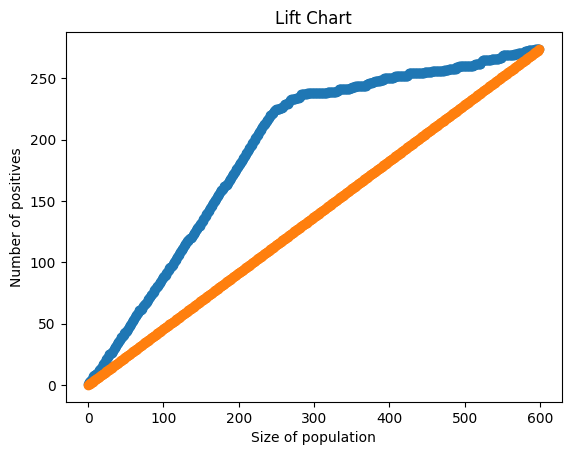

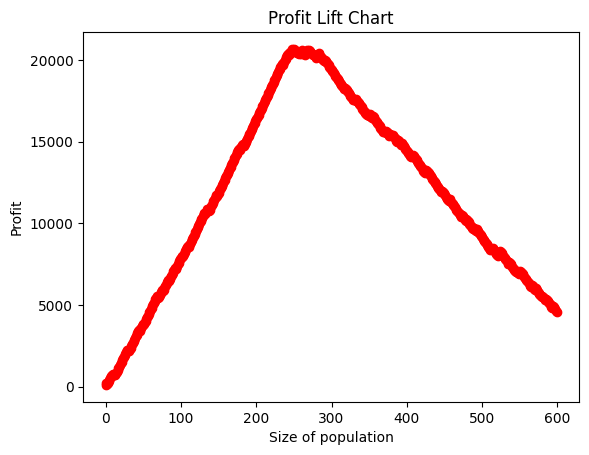

In [13]:
X = training_df_dummy.drop(columns = ['pep'])
y = training_df_dummy.pep

#Get the probability of each record being True
decision_tree_model = DecisionTreeClassifier(criterion = "entropy", max_depth = 6,random_state=0).fit(X,y)
prob_pred = cross_val_predict(decision_tree_model, X, y, cv=10, method="predict_proba")
prob = []
#Choosing on only one of the two probabilities (one is for F, another for T) for each row
for i in range(len(prob_pred)):
    prob.append(prob_pred[i][1])  
prob_pred = np.array(prob)


#Create a dataframe
prob_df = pd.DataFrame()
prob_df['True']=y
prob_df['Prob']=prob_pred
prob_df['TP']=0
prob_df = prob_df.sort_values('Prob', ascending = False)
prob_df = prob_df.reset_index(drop=True)

#Complete the dataframe with the TP (true positive) column
True_Count = 0
for index, row in prob_df.iterrows():
    if(row['True'] == True):
        True_Count += 1
    prob_df['TP'].loc[index] = True_Count

#Calculate what proportion of the population is positive
prop_pos = prob_df['TP'].max() / len(y)
#Plot the lift chart
plot(prob_df.index.values, prob_df.TP, marker='o', linestyle='-')
#Plot the random line
plot(prob_df.index.values, prob_df.index.values * prop_pos, marker='o', linestyle='-', label = 'Random Model')
xlabel('Size of population')
ylabel('Number of positives')
title('Lift Chart')
show()


#Revenue if TP = 100, Cost if FP = 70
cost_matrix = np.array(([100, 70], [0,0]))

#Create the FP (false positive) column
prob_df['FP'] = 0
FP_Count = 0
temp = 0
for index, row in prob_df.iterrows():
    if row['TP'] - temp == 0:
        FP_Count += 1
        prob_df.loc[index, 'FP'] = FP_Count
    else:
        prob_df.loc[index, 'FP'] = FP_Count
    temp = row['TP']

#Calculate the profit
prob_df['Revenue'] = prob_df['TP'] * cost_matrix[0,0]
prob_df['Cost'] = prob_df['FP'] * cost_matrix[0,1]
prob_df['Profit'] = prob_df['Revenue'] - prob_df['Cost']

# Plot the profit lift chart
plot(prob_df.index.values, prob_df.Profit, marker='o', linestyle='-', color='red')
xlabel('Size of population')
ylabel('Profit')
title('Profit Lift Chart')
show()